In [46]:
import numpy as np
from typing import Tuple, Union, Optional, List
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


from collections import Counter
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# KNN Classifier for image

In [141]:
iris = load_iris()
iris.data.shape, iris.target.shape

((150, 4), (150,))

In [142]:
class KNNClassifier:
    """
        KNN classifier implementation from stratch

        this implementation only supports classification, and include the elbow method for finding the optimal k

        Args:
            k (int, optional): Number of neighbors to use for prediction. Defaults to 3.
            X_train (np.ndarray): Training data features
            y_train (np.ndarray): Training data labels or target values
    """

    def __init__(self, k: int = 3):
        """
        Initialize the KNN classifier.

        Args:
            k (int): Number of neighbors to use for prediction. Defaults to 3.
        """
        self.k = k
        self.X_train: Optional[np.ndarray] = None
        self.y_train: Optional[np.ndarray] = None
        self.scaler_fit = StandardScaler()
    
    def fit(self, X_train: np.ndarray, y_train: np.ndarray) -> None:
        """
        Fit the KNN model to the training data.

        Args:
            X (np.ndarray): Training data features.
            y (np.ndarray): Training data labels or target values.
        """
        self.X_train = self.scaler_fit.fit_transform(X_train)
        self.y_train = y_train

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict labels or values for the given data.

        Args:
            X (np.ndarray): Data to predict.

        Returns:
            np.ndarray: Predicted labels or values.
        """
        X_scaled = self.scaler_fit.fit_transform(X)
        return np.array([self.predict_single(x) for x in tqdm(X_scaled, desc="Predicting")])
    
    def predict_single(self, x: np.ndarray) -> Union[int, float]:
        """
        Predict the label or value for a single data point.

        Args:
            x (np.ndarray): Single data point to predict.

        Returns:
            Union[int, float]: Predicted label or value.
        """
        distances = np.sqrt(
            np.sum( (self.X_train - x) ** 2, axis=1 ) # for each row
        )
        k_indices = np.argsort(distances)[: self.k]
        k_nearest_labels = self.y_train[k_indices]

        return int(np.argmax(np.bincount(k_nearest_labels)))
    
    def score(self, X: np.ndarray, y: np.ndarray) -> float:

        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)
    
    def elbow_method(self, X: np.ndarray, y: np.ndarray, max_k: int = 30) -> Tuple[List[int], List[float]]:
        """
        Perform the elbow method to find the optimal K value.

        Args:
            X (np.ndarray): Data features.
            y (np.ndarray): Data labels or target values.
            max_k (int): Maximum K value to consider. Defaults to 20.

        Returns:
            Tuple[List[int], List[float]]: K values and corresponding error rates.
        """
        k_values = list(range(1, max_k + 1))
        error_rates = []
       

        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

        for k in tqdm(k_values, desc="Elbow method: "):
            self.k = k
            self.fit(X_train, y_train)
            error = 1 - self.score(X_val, y_val)
            error_rates.append(error)
        
        return k_values, error_rates
    
    @staticmethod
    def plot_elbow_curve(k_values: List[int], error_rate: List[float]) -> None:
        """
        Plot the elbow curve.

        Args:
            k_values (List[int]): List of K values.
            error_rates (List[float]): Corresponding error rates.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(k_values, error_rate, 'bo-')
        plt.xlabel('K Value')
        plt.ylabel('Error Rate')
        plt.title('Elbow Curve for KNN Classification')
        plt.show()
    


In [143]:
data = load_iris()
X, y = data.data, data.target
X.shape, y.shape

((150, 4), (150,))

Elbow method: 100%|██████████| 30/30 [00:00<00:00, 94.88it/s]


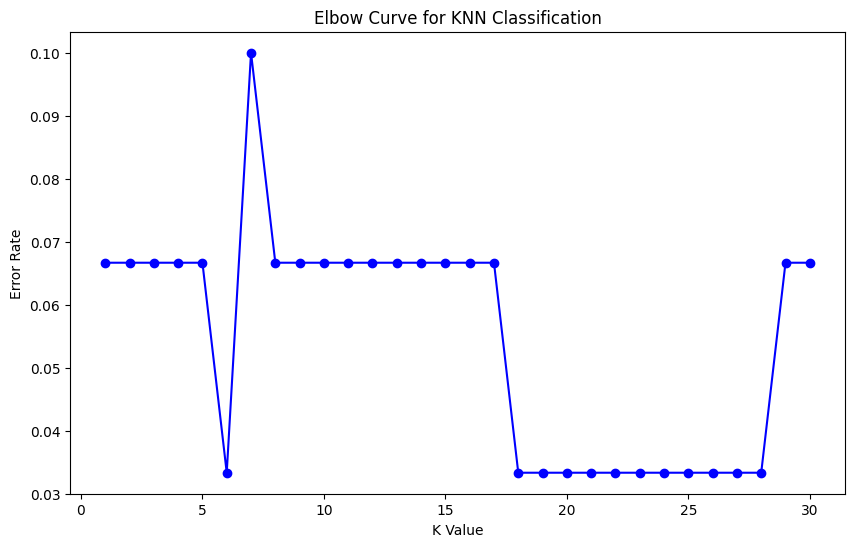

In [144]:
model = KNNClassifier()
k_values, error_rate = model.elbow_method(X, y)
KNNClassifier.plot_elbow_curve(k_values, error_rate)

# Text Classification using KNNClassifier

In [2]:
class KNNTextClassifier:

    def __init__(self, k: int = 3):
        self.k = k
        self.vectorizer = CountVectorizer(binary=True, max_features=5000)
        self.X_train: np.ndarray = None
        self.y_train: np.ndarray = None
    
    def preprocess_text(self, text: str) -> str:
        """Preprocess the input text."""
        # Convert to lowercase and remove special characters
        text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
        return text
    
    def fit(self, X: List[str], y: List[int]):
        """Fit the KNN model to the training data."""
        X_preprocessed = [self.preprocess_text(text) for text in X]
        self.X_train = self.vectorizer.fit_transform(X_preprocessed).toarray()
        self.y_train = np.array(y)
    
    def _predict_single(self, x:np.ndarray) -> int:

        distances = np.sqrt(np.sum(
            (self.X_train - x) ** 2, axis=1 
        ))
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_label = self.y_train[k_indices]

        return Counter(k_nearest_label).most_common(1)[0][0]
    
    def predict(self, X: List[str]) -> np.ndarray:
        X_preprocessed = [self.preprocess_text(text) for text in X]
        X_vectorized = self.vectorizer.transform(X_preprocessed).toarray()
        return np.array([self._predict_single(x) for x in tqdm(X_vectorized, desc="Predicting")])
    

In [53]:
def load_data(file_path: str) -> Tuple[List[str], List[int]]:
    texts, labels = [], []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().rsplit(',')
            text, label = parts[2], parts[1]
            texts.append(text)
            labels.append(int(label))
    return texts, labels

def cross_validate(X: List[str], y: List[int], k: int, n_splits: int = 5) -> float:
    accuracies = []
    for _ in range(n_splits):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        classifier = KNNTextClassifier(k=k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        accuracy = np.mean(y_pred == y_test)
        accuracies.append(accuracy)
    return np.mean(accuracies)
        

In [54]:
X, y = load_data('./dataset/sentiment_analysis.csv')

In [55]:
k_values = [1, 3, 5, 7, 9]
best_k, best_accuracy = 0, 0
for k in k_values:
    accuracy = cross_validate(X, y, k)
    print(f"K = {k}, Accuracy: {accuracy:.4f}")
    if accuracy > best_accuracy:
        best_k, best_accuracy = k, accuracy

print(f"\nBest K: {best_k}")
print(f"Best Accuracy: {best_accuracy:.4f}")

Predicting: 100%|██████████| 1584/1584 [05:44<00:00,  4.60it/s]


K = 1, Accuracy: 0.7081


Predicting: 100%|██████████| 1584/1584 [05:54<00:00,  4.47it/s]


K = 3, Accuracy: 0.7278


Predicting:  38%|███▊      | 601/1584 [02:45<05:34,  2.94it/s]